In [1]:
import time
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [2]:
def to_celsius(image):
    """Convert raw intensity values of radiometric image to Celsius scale."""
    return image*0.04-273.15


def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = to_celsius(frame)
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
        # CLAHE results in vastly different numbers of feature points depending on clipLimit
        #clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
        #frame = clahe.apply(frame)
    return frame

In [3]:
def extract_keypoints_orb(frame):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    orb = cv2.ORB_create(nfeatures=5000, fastThreshold=12)
    kp = orb.detect(frame, None)
    kp, des = orb.compute(frame, kp)
    return kp, des

In [4]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

img_w = 640
img_h = 512
new_camera_matrix = camera_matrix
mapx, mapy = cv2.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, None,
    new_camera_matrix, (img_w, img_h), cv2.CV_32FC1)

In [5]:
def load_image(image_file):
    frame = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)
    frame = preprocess_radiometric_frame(frame, equalize_hist=True
                                        )
    frame = cv2.remap(frame, mapx, mapy, cv2.INTER_CUBIC)
    return frame

In [6]:
#img0 = load_image("frame_001307.tiff")
#img1 = load_image("frame_001308.tiff")

img0 = load_image("frame_004923.tiff")
img1 = load_image("frame_004924.tiff")

In [7]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
distance_threshold = 20.0

In [8]:
kp0, des0 = extract_keypoints_orb(img0)
kp1, des1 = extract_keypoints_orb(img1)

print(len(kp0), len(kp1))

4297 4266


In [9]:
set([kp.octave for kp in kp0])

{0, 1, 2, 3, 4, 5, 6, 7}

In [10]:
# global matching
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x:x.distance)
matches = [m for m in matches if m.distance < distance_threshold]
print("Found {} matches of current frame with last key frame".format(len(matches)))

Found 1217 matches of current frame with last key frame


In [11]:
max_distance = 8.0
mask = np.zeros((len(des0), len(des1)), dtype=np.uint8)
kp1_ = cv2.KeyPoint_convert(kp1).astype(np.uint16)
for i in range(len(kp0)):
    kp0_ = np.array(kp0[i].pt)
    d = (kp1_[:, 0] - kp0_[0])**2 + (kp1_[:, 1] - kp0_[1])**2
    mask[i, d < max_distance**2] = 1

In [ ]:
# find matches between projected map points and descriptors
distance_threshold = 20.0
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)  # set to False
matches = bf.match(map_points_local.representative_orb, des, mask)  # TODO: select only those map points of the local group
#matches = sorted(matches, key = lambda x:x.distance)
# filter out matches with distance (descriptor appearance) greater than threshold
#matches = [m for m in matches if m.distance < distance_threshold]
print("Found {} new matches".format(len(matches)))

In [ ]:
# TODO:
# compute spatial distance between matches
# filter those with too large distance

In [17]:
pts0 = np.array([kp0[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
pts1 = np.array([kp1[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)

match_frame = np.zeros((*img1.shape, 3), dtype=np.uint8)
#draw_params = dict(matchColor = (0,255,0),
#                   singlePointColor = (255,0,0),
#                   matchesMask = None,
#                   flags = cv2.DrawMatchesFlags_DEFAULT)

img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
for m in matches:
    pt1 = (int(kp0[m.queryIdx].pt[0]), int(kp0[m.queryIdx].pt[1]))
    pt2 = (int(kp1[m.trainIdx].pt[0]), int(kp1[m.trainIdx].pt[1]))
    img1 = cv2.line(img1, pt1, pt2, (255,0,0), 3)

#match_frame = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)

Found 1217 matches of current frame with last key frame


In [18]:
match_frame.dtype

dtype('uint8')

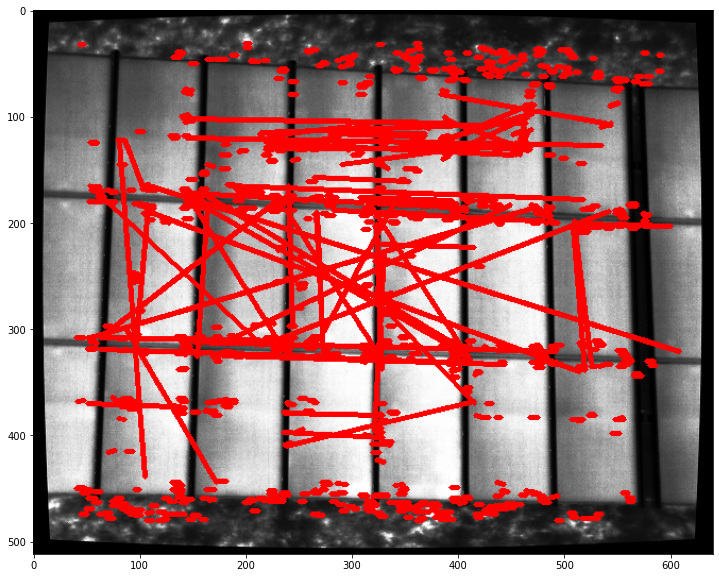

In [19]:
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(img1)
plt.show()